## 从线性回归切入深度学习
假定一个房价预测问题，特征为房屋的面积和房龄，出售价格为标签。收集数据，整理成训练集，验证集，测试集。
接下来我们从直观感受到，特征和标签的关系可能为线性关系，一种可能的表达式为
$$
price = w_{area}*area + w_{age}*age+b
$$

我们希望通过表达式来拟合数据，但是参数w和偏置b是很难确定的，所以定义了损失函数，来量化寻找w和b的目标。损失函数的常用选择是平方差函数。它在评估索引为$i$的样本误差的表达式为：

$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$



$$
L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.
$$

为了求$\textbf L$的最小值，通常要用微积分的做法，即求出函数的极值点，得到极值。

>当模型和损失函数较为简单时，上面的误差最小化问题可以直接用公式表达出来。这类解叫做**解析解(analytical solution)**。
本节的线性回归和平方误差就属于这个范畴。然而，大多数深度学习模型并没有解析解，只能通过优化算法通过有限次迭代模型参数，来尽可能降低损失函数的值。这类解叫做：**数值解（numberical solution）**

在训练数量很大的时候，为了加快学习速度，采用**小批量随机梯度下降(mini-bathc stochastic gradient descent)**，它的算法是：先选取一组模型参数的初始值（一般随机初始化且均值为0，但通常不初始化为0）。

每次迭代中先随即均匀采样一个由固定数目训练数据样本所组成的小批量$\textbf B$，然后求这个小批量中数据样本的损失函数关于模型参数的导数，再对其求平均，乘以\$\eta$（学习率），以此式的结果作为本次迭代模型参数的减小量。

Repeat:{
$$ w:= w-\eta \frac {dL(w)} {dw}
$$
$$ b:= b-\eta \frac {dL(b)} {db}
$$
}


In [1]:
%matplotlib inline
import torch
import time
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random 

print(torch.__version__)

1.4.0


In [2]:
n = 1000
a = torch.ones(n)
b = torch.ones(n)

# 实现一个定时器
class Timer():
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)

In [3]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i]=a[i]+b[i]
print('\'%.5f sec\''% timer.stop())

'0.02394 sec'


In [4]:
timer.start()
d = a + b
print('\'%.10f sec\''% timer.stop())

'0.0000000000 sec'


## 从0实现线性回归

### 生成数据集
使用线性模型来生成数据集，生成一个1000个样本的数据集，下面是用来生成数据的线性关系：

$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$

In [5]:
# 输入的特征数
num_inputs = 2

# 样本数量
num_examples = 1000

# 预设模型的真实参数
true_w = [2, -3.4]
true_b = 4.2

# 生成数据集
# 从均值0，方差1的正态分布中随机取数，返回tensor，即数据集的feature
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
# 给labels增加扰动
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

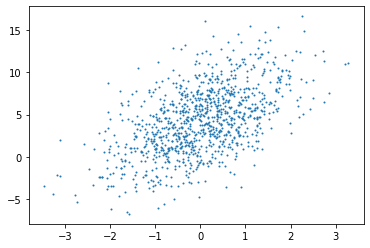

In [6]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1)

### 读取数据集

In [7]:
def data_iter(batch_size, features, labels ):
    """批量读取数据集
    :param batch_size: 读取的数据大小
    :param features: X
    :param labels: y
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 每次迭代都把索引shuffle一下
    
    for i in range(0, num_examples, batch_size):
        # indices是int类型，使用LongTensor类型
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1681,  0.9024],
        [-0.0769, -1.1099],
        [-0.4768,  1.1157],
        [ 0.7533, -1.3403],
        [-1.2582,  0.1543],
        [ 0.7550,  0.1601],
        [-1.5860,  2.2864],
        [ 0.7513,  1.0365],
        [-0.8019, -0.2264],
        [-1.4089, -1.0289]]) 
 tensor([ 0.8070,  7.8180, -0.5512, 10.2563,  1.1465,  5.1708, -6.7657,  2.2068,
         3.3524,  4.8584])


### 初始化模型参数

In [9]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 启动自动求梯度
w.requires_grad_(requires_grad = True)
b.requires_grad_(requires_grad = True)

tensor([0.], requires_grad=True)

### 定义模型
$$
\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b
$$

In [10]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数
使用均方误差损失函数：
$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2,
$$

In [11]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [27]:
y_hat = [2.33, 1.07, 1.23]
y = [3.14, 0.98, 1.32]

y_hat = torch.Tensor(y_hat)
y = torch.Tensor(y)
a = (y_hat - y) ** 2 / 6

a.sum()
# squared_loss(y_hat, y).sum()

tensor(0.1121)

### 定义优化函数

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \frac  {\partial_{(\mathbf{w},b)} l^{(i)}} {\partial(\mathbf{w},b)}
$$

In [13]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad / batch_size # .data https://blog.csdn.net/Gussss/article/details/87705604

### 训练

In [14]:
# 超参数
lr = 0.03
num_epochs = 5

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 求出每批数据的loss
        l = squared_loss(linreg(X, w, b), y).sum()
        # 求每批数据的梯度
        l.backward()
        sgd([w, b], lr, batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.032530
epoch 2, loss 0.000107
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050


In [15]:
# 模型参数与真实值对比
w, true_w, b, true_b

(tensor([[ 1.9999],
         [-3.4000]], requires_grad=True),
 [2, -3.4],
 tensor([4.2003], requires_grad=True),
 4.2)

## 使用pytorch实现线性回归

In [16]:
from torch import nn
torch.manual_seed(1)

torch.set_default_tensor_type('torch.FloatTensor')

### 生成数据集

In [17]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据集

In [18]:
import torch.utils.data as Data

batch_size = 10

# X, y to Tensor format
dataset = Data.TensorDataset(features, labels)

data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2 #多线程读数据
)

In [19]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.9314, -0.1761],
        [-1.5077, -0.2301],
        [ 0.0273, -1.3104],
        [-1.3498,  1.4911],
        [-0.3985, -0.1342],
        [-1.0800, -0.3894],
        [-1.0836, -0.5416],
        [ 0.3100,  0.0282],
        [ 1.0445, -1.2430],
        [-1.1637, -0.4462]]) 
 tensor([ 2.9346,  1.9589,  8.7053, -3.5681,  3.8601,  3.3725,  3.8812,  4.7134,
        10.5209,  3.3930])


### 定义模型


In [20]:
# 定义模型类
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)

In [21]:
# 用torch的api初始化多层网络的方法
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [22]:
from torch.nn import init

# 初始化权重和偏置
init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0) # 或者用 net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

### 初始化模型参数

In [23]:
loss = nn.MSELoss()

### 优化函数

In [24]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 训练

In [25]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss %f'% (epoch, l.item()))

epoch 0, loss 0.000217
epoch 1, loss 0.000038
epoch 2, loss 0.000213
